In [1]:
# lets grab some imports to do our work:
import numpy as np
import pandas as pd
# data source
from pydataset import data
# visualizations:
import matplotlib.pyplot as plt
import seaborn as sns
# modeling:
# data splitting:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# statistical testing:
from scipy import stats

### Acquire Data:

In [4]:
# get our data from the swiss dataset in pydataset
df = data('swiss')

In [5]:
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [7]:
df.describe()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
count,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000
mean,70.142553,50.659574,16.489362,10.978723,41.14383,19.942553
std,12.491697,22.711218,7.977883,9.615407,41.70485,2.912697
min,35.000000,1.200000,3.000000,1.000000,2.15000,10.800000
25%,64.700000,35.900000,12.000000,6.000000,5.19500,18.150000
50%,70.400000,54.100000,16.000000,8.000000,15.14000,20.000000
75%,78.450000,67.650000,22.000000,12.000000,93.12500,21.700000
max,92.500000,89.700000,37.000000,53.000000,100.00000,26.600000


#### Preparation:
 - No nulls in this data set, and everything is numerical.
 - We will split the data at this point.

In [8]:
train_val, test = train_test_split(df, train_size=0.7, random_state=1349)
train, validate = train_test_split(train_val, train_size=0.8, random_state=1349)

In [9]:
train.shape

(25, 6)

In [10]:
from sklearn.preprocessing import MinMaxScaler

#### target: infant mortality: what can we identify in regard to drivers of death in infants with this data set?

In [11]:
X_train, y_train = train.drop(columns='Infant.Mortality'), \
train[['Infant.Mortality']]
X_val, y_val = validate.drop(columns='Infant.Mortality'), \
validate[['Infant.Mortality']]
X_test, y_test = test.drop(columns='Infant.Mortality'), \
test[['Infant.Mortality']]

In [12]:
X_train.head()

,Fertility,Agriculture,Examination,Education,Catholic
Herens,77.3,89.7,5,2,100.00
Martigwy,70.5,78.2,12,6,98.96
Avenches,68.9,60.7,19,12,4.43
St Maurice,65.0,75.9,9,9,99.06
Rive Gauche,42.8,27.7,22,29,58.33


In [13]:
# scaling the data:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [14]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

In [15]:
X_val_scaled = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

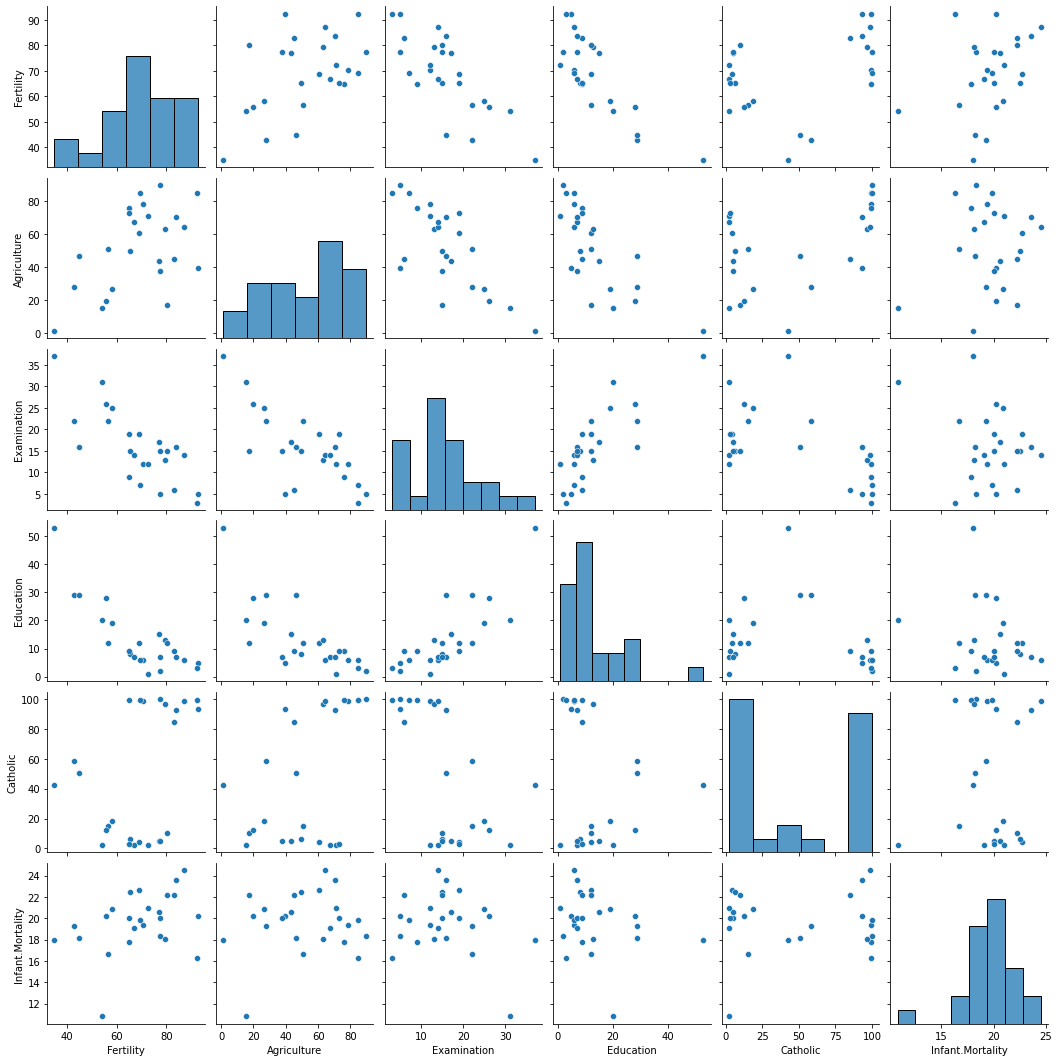

In [16]:
sns.pairplot(train)

In [17]:
# H0: There is no correlation between Fertility and Infant Mortality
# alpha: 0.05
r, p = stats.pearsonr(train['Fertility'], train['Infant.Mortality'])

In [18]:
r

0.3752876361692435

In [19]:
p

0.06451547852021018

In [20]:
# p is not less than alpha and we therefore cannot reject the null hypothesis

In [21]:
# H0: There is no correlation between Catholocism and Infant Mortality
alpha =  0.05
r, p = stats.pearsonr(train['Catholic'], train['Infant.Mortality'])

In [22]:
r

0.040079437625752674

In [23]:
p

0.8491417424891377

In [24]:
p < alpha

False

In [25]:
# We cannot reject the null hypothesis

In [26]:
# let's use some algorithmic feature selection:
bestest = SelectKBest(f_regression, k=3)
bestest.fit(X_train, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x7f9f6b92de50>)

In [27]:
X_train.columns[bestest.get_support()]

Index(['Fertility', 'Examination', 'Education'], dtype='object')

In [28]:
k_columns = X_train.columns[bestest.get_support()].to_list()

In [29]:
k_columns

['Fertility', 'Examination', 'Education']

### Modeling!!

In [30]:
y_train['baseline_mean'] = y_train['Infant.Mortality'].mean()
y_train['baseline_median'] = y_train['Infant.Mortality'].median()

# scores:
rmse_mean = mean_squared_error(y_train['Infant.Mortality'],
                               y_train['baseline_mean'], squared=False)
rmse_med = mean_squared_error(y_train['Infant.Mortality'],
                               y_train['baseline_median'], squared=False)

rmse_mean, rmse_med


(2.7266800325670775, 2.7435743110038042)

In [31]:
# rmse_mean wins here (its lower), we will utilize this as our baseline to beat

In [32]:
# apply the baseline value to the validation target
y_val['baseline_mean'] = y_train['Infant.Mortality'].mean()

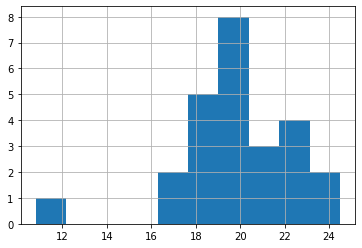

In [33]:
# peek at the distribution of my target varaible
y_train['Infant.Mortality'].hist();

In [34]:
# we are ready to get into modeling:
# I want to do two things here:
# create a metric dataframe for performance comparisons
# create a structure to repeat model output

In [35]:
# lets make a metric df that assesses 
# out of sample model performance
metric_df = pd.DataFrame(
[
    {
        'model': 'baseline_mean',
        'rmse': mean_squared_error(y_val['Infant.Mortality'], y_val.baseline_mean),
        'r^2': explained_variance_score(y_val['Infant.Mortality'], y_val.baseline_mean)
    
    }
])

In [36]:
metric_df

,model,rmse,r^2
0,baseline_mean,10.38733,0.0


In [37]:
# 
# *** Note from review:
# I failed to specify Infant.Mortality in the y of the model's fit call
# which was causing the errors presented before debugging.
# ***
# 
# 
# 

In [38]:
def model_metrics(model, 
                  X_train, 
                  y_train, 
                  X_val, 
                  y_val, 
                  scores=metric_df):
    '''
    model_metrics will use an sklearn model object to 
    create predictions after fitting on our training set, and add
    the model scores to a pre-established metric_df
    returns: metric_df
    **TODO: create a check to see if metric_df exists.  
    Create it if not
    '''
    # fit our model object
    model.fit(X_train, y_train['Infant.Mortality'])
    in_sample_pred = model.predict(X_train)
    out_sample_pred = model.predict(X_val)
    model_name = input('Name for model? python identifer friendly pls.\n')
    y_train[model_name] = in_sample_pred
    y_val[model_name] = out_sample_pred
    print(y_val.shape)
    print(out_sample_pred.shape)
    rmse_val = mean_squared_error(
    y_val['Infant.Mortality'], out_sample_pred, squared=False)
    r_squared_val = explained_variance_score(
        y_val['Infant.Mortality'], out_sample_pred)
    return metric_df.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    
    }, ignore_index=True)

In [39]:
# vanilla linear OLS:
metric_df = model_metrics(LinearRegression(), 
                  X_train_scaled, 
                  y_train, 
                  X_val_scaled, 
                  y_val, 
                  scores=metric_df)

Name for model? python identifer friendly pls.
 ols1


(7, 3)
(7,)


In [41]:
# kbest columns:
metric_df = model_metrics(LinearRegression(), 
                  X_train_scaled[k_columns], 
                  y_train, 
                  X_val_scaled[k_columns], 
                  y_val, 
                  scores=metric_df)

Name for model? python identifer friendly pls.
 selected_feats_ols


(7, 4)
(7,)


In [43]:
# polynomial regresssion:
# first convert our features into the polynomial type, then do an OLS.
polyfeats = PolynomialFeatures(degree=2)
X_train_quad = polyfeats.fit_transform(X_train_scaled)
X_val_quad = polyfeats.transform(X_val_scaled)
metric_df = model_metrics(LinearRegression(), 
                  X_train_quad, 
                  y_train, 
                  X_val_quad, 
                  y_val, 
                  scores=metric_df)

Name for model? python identifer friendly pls.
 quadratic_reg


(7, 5)
(7,)


In [44]:
metric_df

,model,rmse,r^2
0,baseline_mean,10.387330,0.000000
1,ols1,2.774954,0.212887
2,selected_feats_ols,2.809074,0.208283
3,quadratic_reg,4.104727,-0.593668


In [ ]:
# selected model for Test set: ols1, vanilla regression model

In [ ]:
# TODO for exemplification:
# visualize residuals